# **Lab 2 - Explainable and Trustworthy AI**


---



**Eleonora Poeta** (eleonora.poeta@polito.it)

**Lab 2:** Global post-hoc explainable models on structured data

# **Permutation Feature Importance**


---



*	Permutation feature importance is a model inspection technique that measures the **contribution** of **each feature** to the **model's performances** on a  given tabular dataset.
* A **feature** is **important** if shuffling its values, the ***model error increases***. So, the model relied on that feature for the prediction.


Key **advantages** of Permutation Feature importance technique:


> * Nice and **direct interpretation** of the model's behaviour.
* It is **model-agnostic**.
* It does **not require retraining the model**.



Main **disadvantages** of Permutation Feature importance technique:


> * It assumes the **Feature independence**. If features are correlated, it can be biased by unrealistic data instances.
* It is strictly linked to the **model performance measures**. In some cases other measures can be of interest.




---


## **Exercise 1**

The [**Titanic**](https://www.openml.org/search?type=data&sort=runs&id=40945&status=active) dataset describes the survival status of individual passengers on the Titanic. In this exercise you have to:

* **Preprocess** the Titanic dataset. You can follow these main steps:
> * **Load** the dataset
  * **Split** the dataset into training and test set using the **80/20** ratio. **Shuffle** the dataset and **stratify** it using the target variable.
  * Fill **null** values. `age` column with the mean, `fare` with the median and `embarked` with the most frequent values.
  * Encoding
    * **Remove** columns that are *not informative for the final task*, or that *contain information about target variable*.
    * Perform **OneHotEncoding** and **OrdinalEncoder**, where needed.
    * Perform **MinMax** scaling, where needed,
    * We suggest to use the **[ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)** module

* Fit a **[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)()** over the Titanic dataset. We suggest to use the **[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)** module
* Inspect model's **accuracy** on training and test dataset.

### **Exercise 1.1**
* Calculate **Feature Importances** (as previously done in Lab 1):
> * What can you infer? What is the most important feature? Is it categorical or numerical?
> Note that you can aggregate (via sum) the feature importance for the feature value importance of the same categorical attribute to have the importance of the attribute

### **Exercise 1.2**
* Now, compute [**permutation_importance**](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).
>   * **Firstly**, compute this for the **test set**. What are the most important features?
    * Re-do the computation of permutation_importance, now **on the training set**. Did you obtain the same result as for the test set? If not, what can be the problem?

### **Exercise 1.3**
* Let's now instanciate another **RandomForestClassifier** with parameter `min_samples_leaf=20`.
> * Repeat the steps for computing the permutation_importance on both training and test set.
  * Has something changed? What can you infer about RandomForestClassifier's behaviour with respect to overfitting?


***Hint***:

> In the first case, the results of permutation_importance on the training and test set can be explained by overfitting of the RandomForestClassifier. So, the RF has capacity to use the feature `fare` to overfit.












## **Solution:**

### Data preprocessing - Titanic dataset

In [2]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0


In [3]:
df.drop(['name','ticket', 'cabin','boat', 'body', 'home.dest'], axis=1, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1), df['survived'], test_size=0.2, random_state=42, shuffle=True, stratify=df['survived'])

age_mean = X_train['age'].mean()
fare_median = X_train['fare'].median()
most_frequent_embarked = X_train['embarked'].mode()[0]

In [5]:
# Working with missing values
X_train['age'].fillna(age_mean, inplace=True)
X_train['fare'].fillna(fare_median, inplace=True)
X_train['embarked'].fillna(most_frequent_embarked, inplace=True)

X_test['age'].fillna(age_mean, inplace=True)
X_test['fare'].fillna(fare_median, inplace=True)
X_test['embarked'].fillna(most_frequent_embarked, inplace=True)

In [6]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked
999,3,female,29.604316,0,0,7.7500,Q
392,2,female,24.000000,1,0,27.7208,C
628,3,female,11.000000,4,2,31.2750,S
1165,3,male,25.000000,0,0,7.2250,C
604,3,female,16.000000,0,0,7.6500,S


In [7]:
X_test.head()

,pclass,sex,age,sibsp,parch,fare,embarked
1028,3,female,29.604316,1,0,24.1500,Q
1121,3,male,29.604316,1,1,22.3583,C
1155,3,male,29.604316,0,0,7.7750,S
1251,3,male,30.500000,0,0,8.0500,S
721,3,male,36.000000,0,0,7.4958,S


In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

column_transformer = ColumnTransformer(
    transformers=[
        ('pclass_one_hot', OneHotEncoder(), ['pclass']),
        ('sex_one_hot', OneHotEncoder(), ['sex']),
        ('age_scale', MinMaxScaler(), ['age']),
        ('sibsp_scale', MinMaxScaler(), ['sibsp']),
        ('parch_scale', MinMaxScaler(), ['parch']),
        ('fare_log_scale', Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p, validate=False)),  # Apply log transformation
            ('scale', MinMaxScaler())]), ['fare']),
        ('embarked_one_hot', OneHotEncoder(), ['embarked']),
    ])


In [9]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('pclass_one_hot', OneHotEncoder(), ['pclass']),
                                ('sex_one_hot', OneHotEncoder(), ['sex']),
                                ('age_scale', MinMaxScaler(), ['age']),
                                ('sibsp_scale', MinMaxScaler(), ['sibsp']),
                                ('parch_scale', MinMaxScaler(), ['parch']),
                                ('fare_log_scale',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scale', MinMaxScaler())]),
                                 ['fare']),
                                ('embarked_one_hot', OneHotEncoder(),
                                 ['embarked'])])

In [10]:
transformed_Xtrain = column_transformer.transform(X_train)
transformed_Xtest = column_transformer.transform(X_test)

#### Fit the Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to the transformed training data
rf_classifier.fit(transformed_Xtrain, y_train)

# Predict the target variable for the transformed test data
y_pred = rf_classifier.predict(transformed_Xtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 78.24%


### Exercise 1.b

#### Calculate the Feature Importances

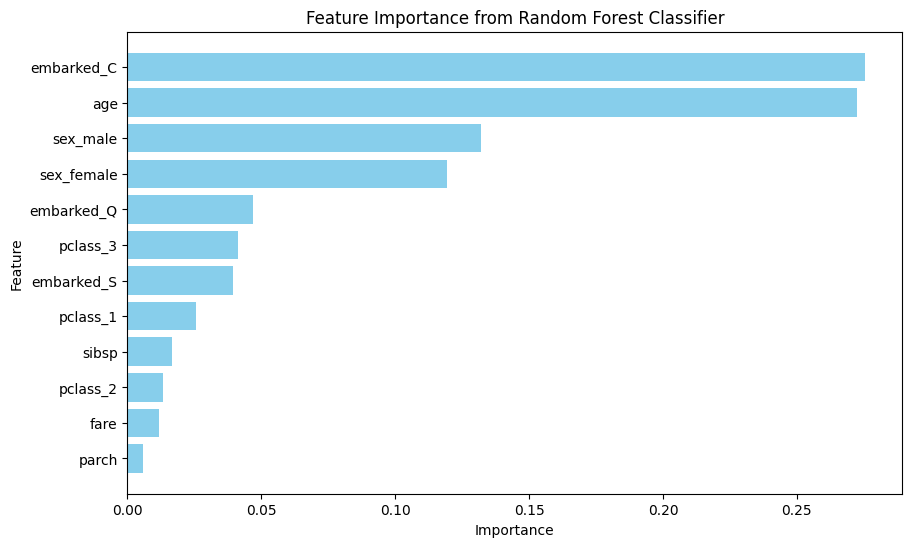

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the model
importances = rf_classifier.feature_importances_

# Handle one-hot encoded features: create column names for one-hot encoded features
one_hot_features_pclass = column_transformer.named_transformers_['pclass_one_hot'].get_feature_names_out(['pclass'])
one_hot_features_sex = column_transformer.named_transformers_['sex_one_hot'].get_feature_names_out(['sex'])
one_hot_features_embarked = column_transformer.named_transformers_['embarked_one_hot'].get_feature_names_out(['embarked'])

# Combine the feature names in the order they were transformed
features = np.concatenate([one_hot_features_pclass, one_hot_features_sex, one_hot_features_embarked, ['age', 'sibsp', 'parch', 'fare']])

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()


### Exercise 1.b

#### Permutation Importances

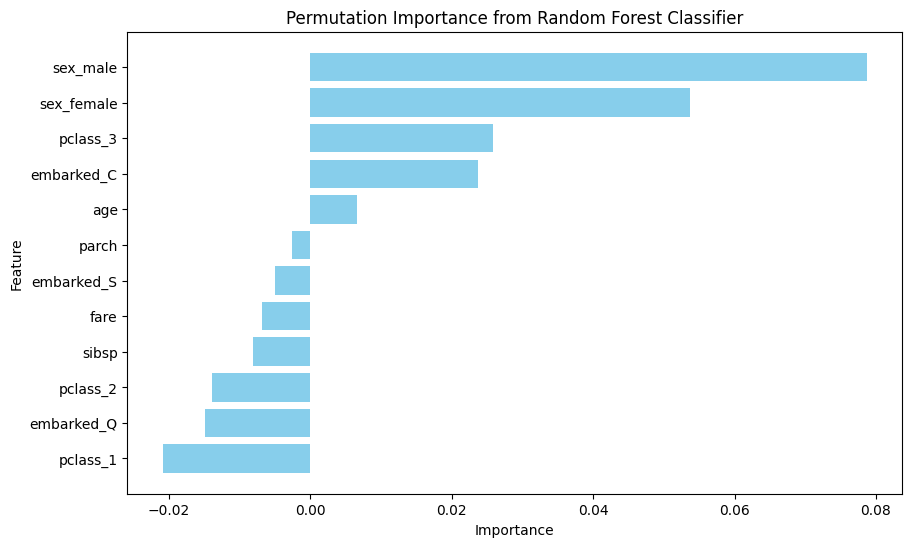

In [13]:
from sklearn.inspection import permutation_importance

# Calculate the permutation importances
perm_importance = permutation_importance(rf_classifier, transformed_Xtest, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

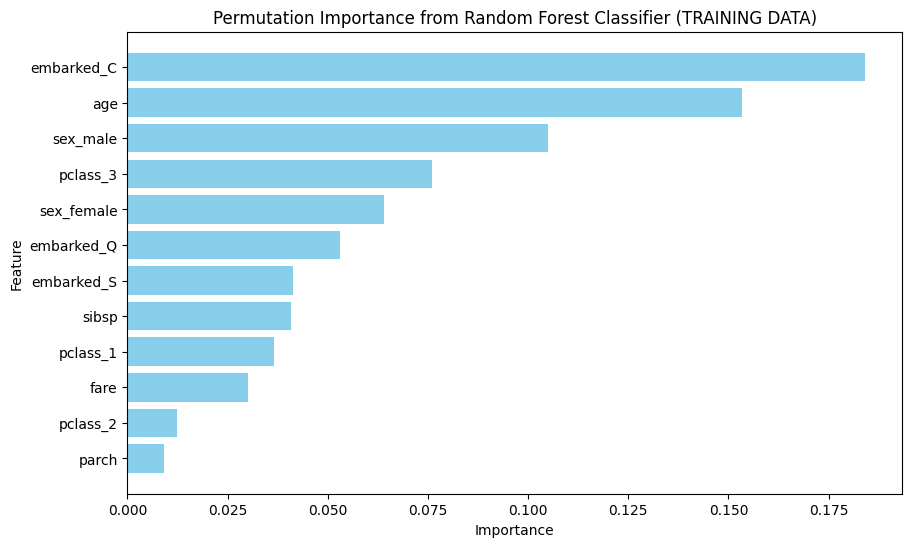

In [14]:
# Calculate the permutation importances
perm_importance = permutation_importance(rf_classifier, transformed_Xtrain, y_train, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier (TRAINING DATA)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

- Interpretation of differences:
1. Data distribution: The data dist in the training data differs from the test data, this can occus if the split wasn't random or if the dataset has temporal or group-related structures.
2. NOISE: In a small number of repeats, the importance estimation can be noisy.
3. Feature Interactions: The RF may capture some interactions between features which is in turn, different between train and test sets.
4. Sampling size and amount of data

- Possible imporvements (porposed but not implemented):
1. Cross-validation
2. Regularization
3. Feature Selection
4. Data investigation and EDA
5. Model complexity  

### Exercise 1.3

Set the **min_samples_leaf at 20** and fit a random forest classifier

In [15]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(min_samples_leaf=20,random_state=42)

# Fit the classifier to the transformed training data
rf_classifier.fit(transformed_Xtrain, y_train)

# Predict the target variable for the transformed test data
y_pred = rf_classifier.predict(transformed_Xtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 84.35%


Permutation importances

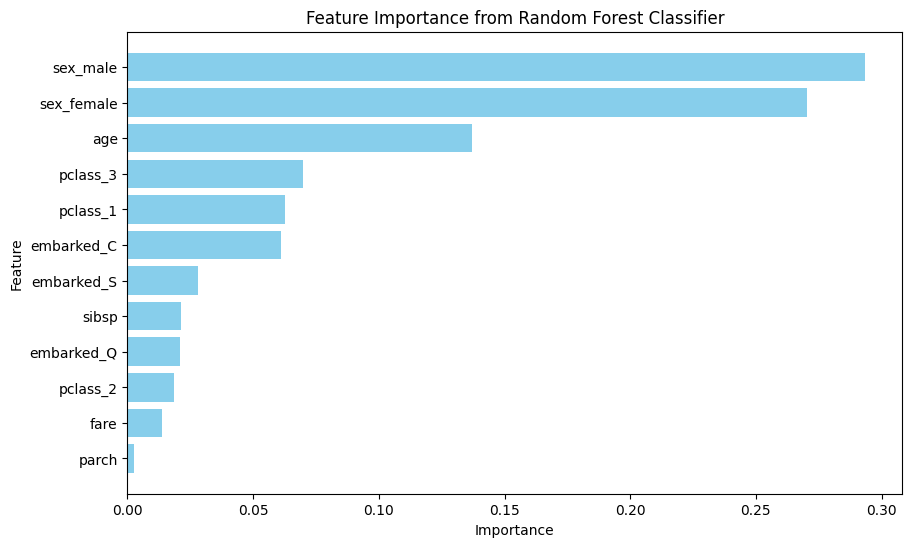

In [16]:
# Extract feature importances from the model
importances = rf_classifier.feature_importances_

# Handle one-hot encoded features: create column names for one-hot encoded features
one_hot_features_pclass = column_transformer.named_transformers_['pclass_one_hot'].get_feature_names_out(['pclass'])
one_hot_features_sex = column_transformer.named_transformers_['sex_one_hot'].get_feature_names_out(['sex'])
one_hot_features_embarked = column_transformer.named_transformers_['embarked_one_hot'].get_feature_names_out(['embarked'])

# Combine the feature names in the order they were transformed
features = np.concatenate([one_hot_features_pclass, one_hot_features_sex, one_hot_features_embarked, ['age', 'sibsp', 'parch', 'fare']])

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

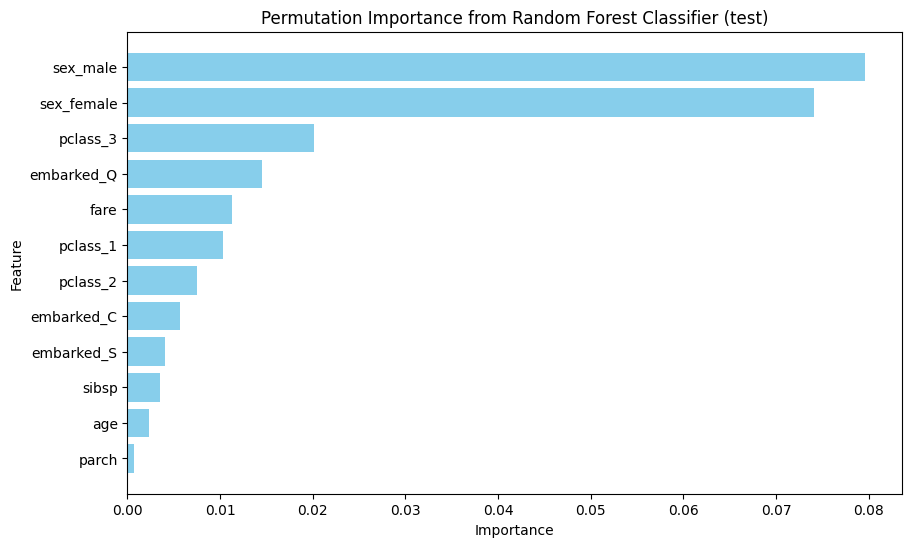

In [17]:
# Calculate the permutation importances
perm_importance = permutation_importance(rf_classifier, transformed_Xtest, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier (test)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

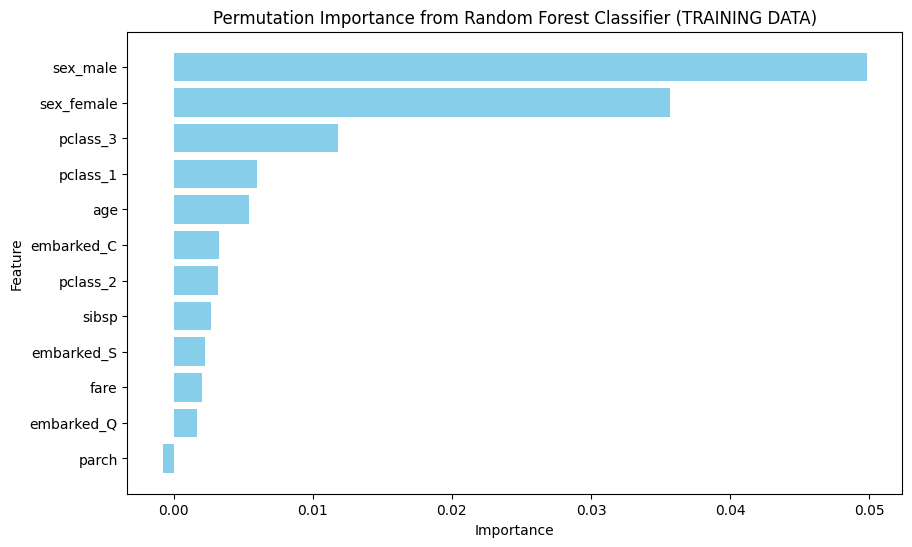

In [18]:
# Calculate the permutation importances
perm_importance = permutation_importance(rf_classifier, transformed_Xtrain, y_train, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier (TRAINING DATA)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

# **Partial dependence plot**


---



The **Partial Dependence Plot** (in short, PDP) shows the **marginal effect** of one or two features **on the predicted outcome** of a Machine learning model.

* It is a **global method**: The method considers **all instances** and gives a statement about the **global relationship** of a feature with the predicted outcome.

Key **Advantages**:

* The PDP computation is really **intuitive**.
* By providing an **explanation** in the form of a **visualization**, it is easy to inspect.


Main **Disadvantages**:

* The **assumption** of **independence** is the biggest issue with PDP plots.
* The **realistic maximum number of features** in a partial dependence function is **two**.



---

# **Exercise 2**

* Instanciate and Fit a [**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and a [**RandomForestClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) over Titanic dataset.
* **Evaluate** both models by inspecting their **accuracy** scores over train and test dataset.
* Print **Feature Importances** for both models.
* Generate the **PDP** using [**PartialDependenceDisplay.from_estimator**](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.PartialDependenceDisplay.html) function for both models.


## **Solution:**

RF Classifier

In [19]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(min_samples_leaf=20,random_state=42)

# Fit the classifier to the transformed training data
rf_classifier.fit(transformed_Xtrain, y_train)

# Predict the target variable for the transformed test data
y_pred = rf_classifier.predict(transformed_Xtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 84.35%


DT classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(min_samples_leaf=20,random_state=42)

# Fit the classifier to the transformed training data
dt_classifier.fit(transformed_Xtrain, y_train)

# Predict the target variable for the transformed test data
y_pred = dt_classifier.predict(transformed_Xtest)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 80.53%


Plot the feature importance for Random Forest

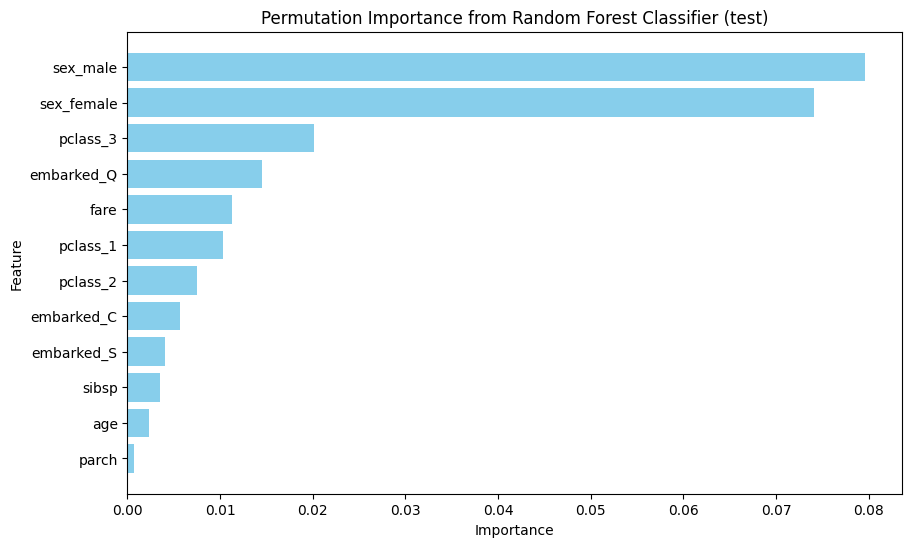

In [21]:
# Calculate the permutation importances
perm_importance = permutation_importance(rf_classifier, transformed_Xtest, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier (test)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

Plot the feature importance for decision tree

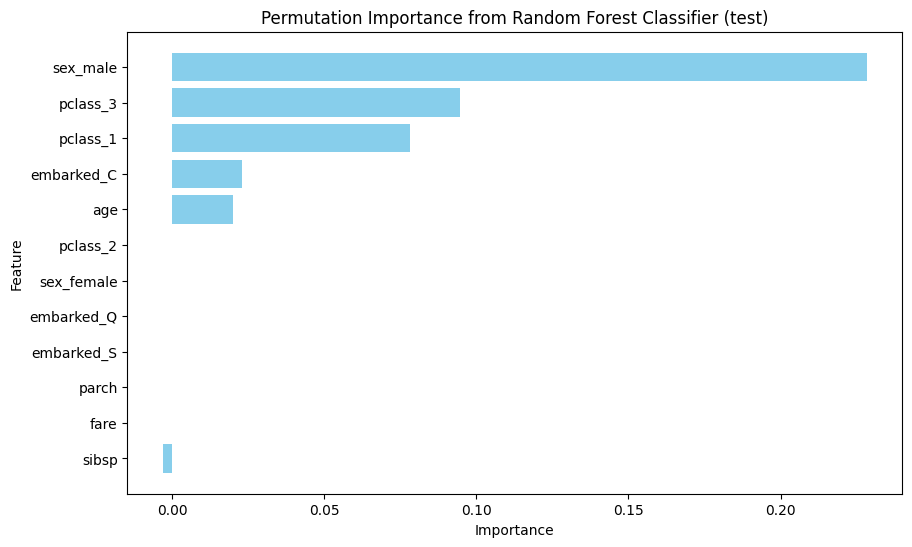

In [22]:
# Calculate the permutation importances
perm_importance = permutation_importance(dt_classifier, transformed_Xtest, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for permutation importances
perm_importance_df = pd.DataFrame({'feature': features, 'importance': perm_importance.importances_mean})

# Sort the DataFrame by importance
perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['feature'], perm_importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importance from Random Forest Classifier (test)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

Generate PDP for Random Forest Classifier

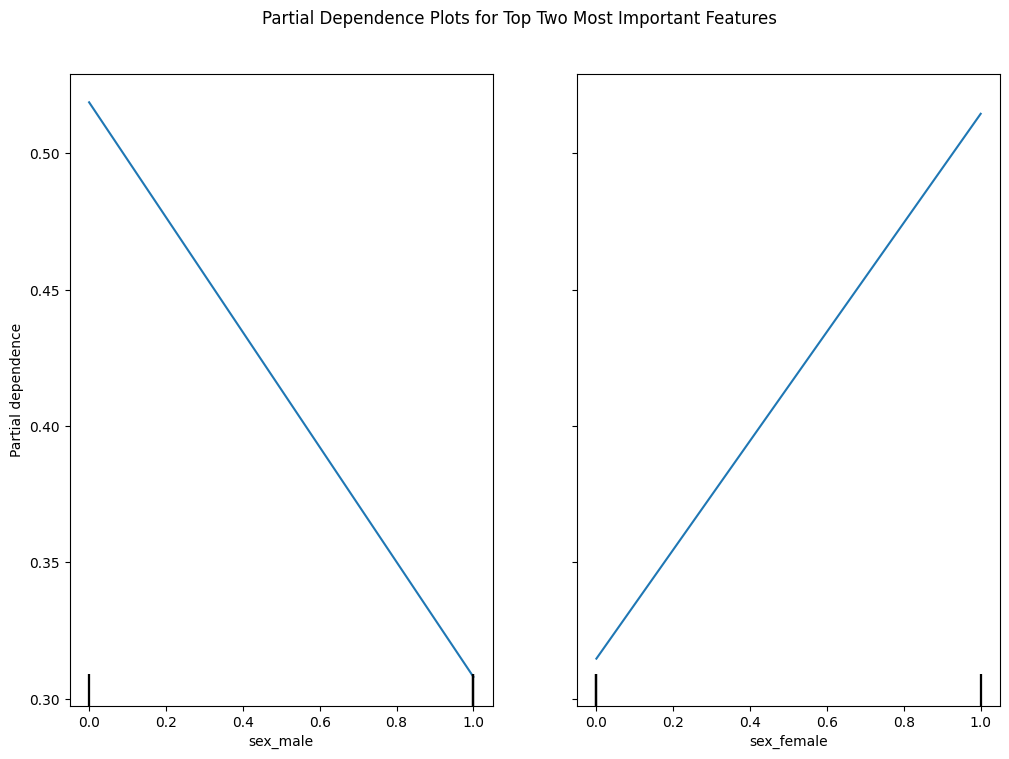

In [23]:
from sklearn.inspection import PartialDependenceDisplay

# Choose the features for which you want to plot the PDP
top_two_features = feature_importances['feature'][:2].values

# Convert feature names to indices
# The plot_partial_dependence function expects integers or feature names that match the ones passed during fit
feature_indices = [list(features).index(feature) for feature in top_two_features]

# Now, generate the PDP for these features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    rf_classifier,
    X=transformed_Xtrain,
    features=feature_indices,
    feature_names=features,
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Two Most Important Features")
plt.subplots_adjust(top=0.9)  # Adjust title spacing
plt.show()

Generate PDP for Decision Tree Classifier

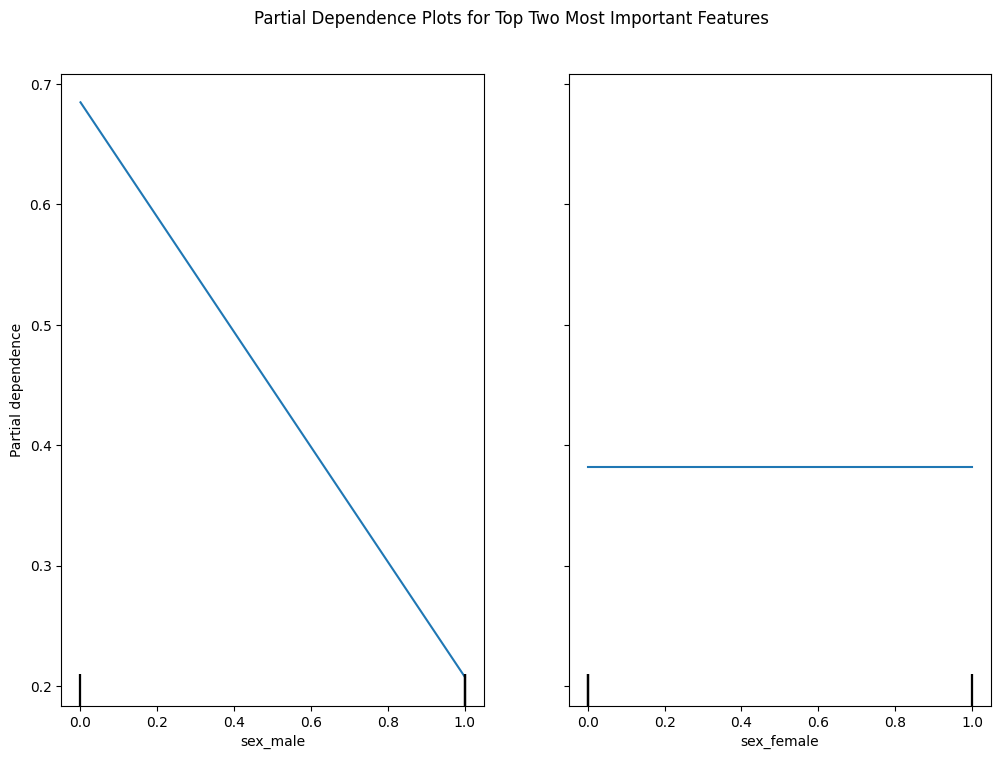

In [24]:
from sklearn.inspection import PartialDependenceDisplay

# Choose the features for which you want to plot the PDP
top_two_features = feature_importances['feature'][:2].values

# Convert feature names to indices
# The plot_partial_dependence function expects integers or feature names that match the ones passed during fit
feature_indices = [list(features).index(feature) for feature in top_two_features]

# Now, generate the PDP for these features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    dt_classifier,
    X=transformed_Xtrain,
    features=feature_indices,
    feature_names=features,
    ax=ax
)
plt.suptitle("Partial Dependence Plots for Top Two Most Important Features")
plt.subplots_adjust(top=0.9)  # Adjust title spacing
plt.show()

# **Global surrogate models**


---



The purpose of (interpretable) surrogate models is to **approximate** the **predictions** of the underlying model *as accurately as possible* and to be interpretable at the same time.

The surrogate model is a **model-agnostic method**, since it does **not require** any **information** about the **inner workings of the black box model**, *only access to data and the prediction function is necessary*.

To **obtain a surrogate model** you have to perform the following steps:



1.   Select a dataset X.
2.   For the selected dataset X, get the predictions of the black box model.
3.   Select an interpretable model type (linear model, decision tree, …).
4.   Train the interpretable model on the dataset X and its predictions.

Congratulations! You now have a surrogate model!

Measure **how well** the **surrogate model replicates the predictions of the black box model** to interpret the model.



---

## **Exercise 3:**

The aim of this exercise is to use a white-box model, that is the surrogate model, to explain the black-box model. You have to:

* Instanciate and fit the **black-box** model, i.e. the [**GradientBoosterClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) over the Titanic
dataset.
> * You can retrieve the predictions with the *_predictions* function.



* Instanciate and fit the **white-box** model, i.e. the [**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) over the Titanic dataset **and** the predictions of the black-box model.
* Calculate the **accuracy_score** for both models on the training and test dataset.
* Calculate the **reconstruction_error** for both models on the training and test dataset.
* **Print** the obtained **results**.

***Hint:***
> You can inted the **reconstruction_error** as the loss of information or performance when using the predictions of the black-box model to train the white-box model.

## **Solution:**

Train the black-box model

In [25]:
transformed_Xtrain.shape, transformed_Xtest.shape

((1047, 12), (262, 12))

In [26]:
raise ValueError("Stop here")

ValueError: Stop here

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

black_box_model = GradientBoostingClassifier(random_state=42)
black_box_model.fit(transformed_Xtrain, y_train)

# Get the predictions from the black-box model
black_box_train_predictions = black_box_model.predict(transformed_Xtrain)
black_box_test_predictions = black_box_model.predict(transformed_Xtest)

In [ ]:
# Extend the original dataset with the predictions of the black-box model
X_train_extended = np.column_stack((transformed_Xtrain, ))
X_test_extended = np.column_stack((transformed_Xtest, black_box_test_predictions))

Train the white-box model over the Titanic dataset and the predictions from the black-box model.

In [ ]:
white_box_model = LogisticRegression(max_iter=1000, random_state=42)
white_box_model.fit(transformed_Xtrain, black_box_train_predictions)
#can0
white_box_coefficients = white_box_model.coef_

Evaluate the performances of black-box and white-box models.

In [ ]:
black_box_train_accuracy = accuracy_score(y_train, black_box_train_predictions)
black_box_test_accuracy = accuracy_score(y_test, black_box_test_predictions)
white_box_train_accuracy = accuracy_score(y_train, white_box_model.predict(X_train_extended))
white_box_test_accuracy = accuracy_score(y_test, white_box_model.predict(X_test_extended))

print("Black-box model (Gradient Boosting Classifier):")
print(f"Training accuracy: {black_box_train_accuracy:.4f}")
print(f"Test accuracy: {black_box_test_accuracy:.4f}\n")

print("White-box model (Logistic Regression):")
print(f"Training accuracy: {white_box_train_accuracy:.4f}")
print(f"Test accuracy: {white_box_test_accuracy:.4f}\n")

Black-box model (Gradient Boosting Classifier):
Training accuracy: 0.8606
Test accuracy: 0.8130

White-box model (Logistic Regression):
Training accuracy: 0.8606
Test accuracy: 0.8130



Evaluate the reconstruction error

In [ ]:
reconstruction_error_train = black_box_train_accuracy - white_box_train_accuracy
reconstruction_error_test = black_box_test_accuracy - white_box_test_accuracy

print("Reconstruction Error:")
print(f"Training: {reconstruction_error_train:.4f}")
print(f"Test: {reconstruction_error_test:.4f}\n")

print("White-box model coefficients:")
print(white_box_coefficients)

Reconstruction Error:
Training: 0.0000
Test: 0.0000

White-box model coefficients:
[[ 0.46945536 -0.27053516 -0.19930696  0.41863047 -0.41901723 -0.82225589
  -0.99498985 -0.11200798  0.19348679  0.42272948 -0.5447923   0.12167606
   2.90402421]]
